In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3f499177210be216ceaa319ee9bcbe97dc214a1e3c907903a8ef3780a63ae4c5
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=545ef1629dbf01975d006a9124daca80948e60d99c379886fcfb75038f8c772c
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyLDAvis sklearn


In [ ]:
# import modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.datasets import fetch_20newsgroups
import nltk
import gensim  
from gensim import models 
from gensim.corpora.dictionary import Dictionary 
from gensim.models import CoherenceModel 
from gensim import corpora 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases
import pyLDAvis 
import pyLDAvis.gensim_models

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# read the text data
newsgroups_train = fetch_20newsgroups(subset='train').data
len(newsgroups_train)

11314

In [ ]:
newsgroups_test = fetch_20newsgroups(subset='test').data
len(newsgroups_test)

7532

In [ ]:
# check the text data
newsgroups_train[:2]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

# Tokenize data

In [ ]:
# tokenize data 
word_tokenize = \
[gensim.utils.simple_preprocess(word, min_len=3) for word in newsgroups_train]
# keep only alphabetical characters
clean_tokens = \
[[word for word in doc if word.isalpha()] for doc in word_tokenize]
# remove stop words
no_stops = \
[[t for t in doc if t not in stopwords.words("english")] for doc in clean_tokens]
# instantiate WordNetLemmatizer
lem = WordNetLemmatizer()
# lemmatize tokens 
lemmatized = [[lem.lemmatize(t) for t in doc] for doc in no_stops]
# compute bigrams 
bigram = Phrases(lemmatized, min_count=20, threshold=100)
trigram = Phrases(bigram[lemmatized], threshold=100)
for ind, elem in enumerate(lemmatized):
  for token in bigram[lemmatized][ind]:
    if "_" in token:
      lemmatized[ind].append(token)
  for token in trigram[lemmatized][ind]:
    if "_" in token:
      lemmatized[ind].append(token)

# Create corpus

In [ ]:
# create dictionary
dictionary = corpora.Dictionary(lemmatized)
# filter out non frequent words and too frequent words 
dictionary.filter_extremes(no_below=20, no_above=.5)
corpus = [dictionary.doc2bow(text) for text in lemmatized]

# Number of topics

In [ ]:
# compute coherence value for different topic numbers
cherence_lda = []
for v in range(10, 25, 1):
  ldamodel = models.LdaModel(corpus, 
                             num_topics=v, 
                             id2word=dictionary, 
                             passes=100)
  coherence_model = \
  CoherenceModel(model=ldamodel, texts=lemmatized, 
                 dictionary=dictionary, coherence='c_v')
  coherence_value = coherence_model.get_coherence()
  cherence_lda.append(coherence_value)

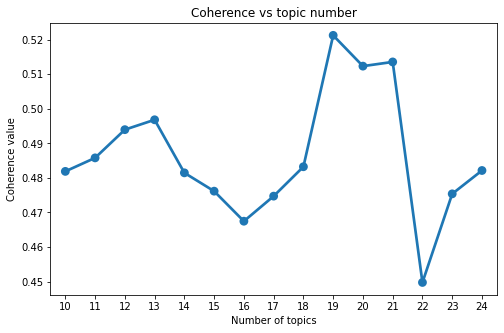

In [ ]:
# visualize coherence values vs number of topics
plt.figure(figsize=(8, 5))
sns.pointplot(x=list(range(10, 25, 1)), y=cherence_lda)
plt.xlabel("Number of topics")
plt.ylabel("Coherence value")
plt.title("Coherence vs topic number")
plt.show()

We can clearly see that the model with 19 topics has the highest Coherence score. Train the model with 19 topics.

# LDA model

In [ ]:
# LDA model with 19 topics
ldamodel = models.LdaModel(corpus, 
                           num_topics=19, 
                           id2word=dictionary, 
                           passes=50, 
                           eval_every=None, 
                           alpha='auto', 
                           eta='auto', 
                           chunksize=1000, 
                           iterations=200)

In [ ]:
# print topics
ldamodel.print_topics(num_words=15)

[(0,
  '0.045*"space" + 0.038*"nasa" + 0.035*"gov" + 0.013*"jpl_nasa" + 0.010*"local_bus" + 0.010*"space_shuttle" + 0.010*"launch" + 0.010*"moon" + 0.010*"prism_gatech" + 0.009*"henry" + 0.009*"jpl" + 0.009*"article" + 0.009*"shuttle" + 0.009*"orbit" + 0.008*"space_station"'),
 (1,
  '0.024*"andrew_cmu" + 0.019*"hockey" + 0.018*"uiuc" + 0.018*"andrew" + 0.016*"university_illinois" + 0.015*"article" + 0.014*"university" + 0.013*"cmu" + 0.011*"cso" + 0.010*"colorado" + 0.008*"frank" + 0.008*"illinois" + 0.008*"cso_uiuc" + 0.007*"carnegie_mellon" + 0.007*"sgi"'),
 (2,
  '0.014*"wire" + 0.013*"power" + 0.011*"purdue" + 0.011*"ecn_purdue" + 0.011*"ground" + 0.010*"circuit" + 0.010*"power_supply" + 0.009*"signal" + 0.009*"input" + 0.008*"mil" + 0.008*"university" + 0.008*"navy" + 0.008*"supply" + 0.008*"get_rid" + 0.008*"use"'),
 (3,
  '0.023*"armenian" + 0.014*"turkish" + 0.011*"war" + 0.010*"stanley_cup" + 0.010*"people" + 0.009*"greek" + 0.008*"turk" + 0.007*"freenet_carleton" + 0.007*"tu

# Assign topics to the original data

In [ ]:
# create DF with topics and probability scores for each text
topic_details = pd.DataFrame()
for i, row in enumerate(ldamodel[corpus]):
  row = sorted(row, key=lambda x: (x[1]), reverse=True)
  for j, (topic_num, prop_topic) in enumerate(row):
    if j==0:
      topic_details = topic_details.append(
          pd.Series([topic_num, prop_topic]), ignore_index=True
      )
topic_details.columns=["Topics", "% Score"]

In [ ]:
# assign tokens and original texts to the topics
topic_details.loc[:, 'Tokens'] = np.array(lemmatized, dtype='object')
topic_details.loc[:, 'Original text'] = newsgroups_train

In [ ]:
topic_details.loc[40:45]

,Topics,% Score,Tokens,Original text
40,9.0,0.356886,"[sean, garrison, subject, bonilla, nntp, posti...",From: (Sean Garrison)\nSubject: Re: Bonilla\n...
41,7.0,0.510100,"[root, ncube, com, operator, subject, fax, mod...",From: root@ncube.com (Operator)\nSubject: Re: ...
42,14.0,0.367355,"[cleveland, freenet, edu, sam, latonia, subjec...",From: ab245@cleveland.Freenet.Edu (Sam Latonia...
43,9.0,0.290688,"[paul, csd, csd, uwm, edu, paul, krueger, subj...",From: paul@csd4.csd.uwm.edu (Paul R Krueger)\n...
44,9.0,0.313854,"[cmeyer, bloch, stanford, edu, craig, meyer, s...",From: cmeyer@bloch.Stanford.EDU (Craig Meyer)\...
45,1.0,0.425725,"[robert, everett, brunskill, andrew, cmu, edu,...",From: Robert Everett Brunskill <rb6t+@andrew.c...


# Visualize topics

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.198076 -0.060066       1        1  22.829076
6      0.180213 -0.048669       2        1  10.064069
11     0.220289 -0.104047       3        1   9.086307
14     0.166381  0.147539       4        1   8.591520
7     -0.102420  0.114160       5        1   8.259708
18     0.170832  0.128950       6        1   6.920363
17     0.050851  0.059270       7        1   4.078625
8      0.038757  0.038405       8        1   3.726320
5     -0.018026 -0.114748       9        1   3.535747
10    -0.045500 -0.078596      10        1   3.307442
3      0.085129 -0.275349      11        1   3.185640
13    -0.051407  0.149871      12        1   3.131194
1     -0.157282 -0.006349      13        1   2.672407
0     -0.075932  0.074379      14        1   2.158768
16    -0.139467 -0.150151      15        1   2.088442
2      0.035458  0.165575      16        1   1.859478
12    -0.187138 -0.035725      17        1   1.725355
15    -0.184144  0.061070      18        1   1.603402
4     -0.184670 -0.065518      19        1   1.176139, topic_info=              Term          Freq         Total Category  logprob  loglift
30    nntp_posting  14510.000000  14510.000000  Default  30.0000  30.0000
216            com  12607.000000  12607.000000  Default  29.0000  29.0000
2289           max   4037.000000   4037.000000  Default  28.0000  28.0000
33         posting   5785.000000   5785.000000  Default  27.0000  27.0000
16            host   5060.000000   5060.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
216            com    216.711303  12607.715101  Topic19  -4.4680   0.3794
778            air    126.417218    501.962160  Topic19  -5.0070   3.0640
1963        public    134.899483   1512.808768  Topic19  -4.9420   2.0257
55         article    144.726959   7806.284542  Topic19  -4.8717   0.4551
1365          unix    125.047099    743.449322  Topic19  -5.0179   2.6603

[1040 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6291     11  0.992750          abc
3784      5  0.907517           ac
3784     11  0.091124           ac
7069      5  0.994092  ac_ucalgary
5386      5  0.994572  acad_alaska
...     ...       ...          ...
947       9  0.998765         york
4044     14  0.991031          zoo
4045     14  0.996293  zoo_toronto
2537     11  0.993361         zuma
2538     11  0.994911    zuma_uucp

[2277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 12, 15, 8, 19, 18, 9, 6, 11, 4, 14, 2, 1, 17, 3, 13, 16, 5])